In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, MobileViTV2ForImageClassification
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

# Check and create output directory
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

c:\Users\thanh-dung.le\.conda\envs\torch-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global parameters
USE_CUDA = torch.cuda.is_available()
DATASET_PATH = 'C:\\Users\\thanh-dung.le\\Documents\\EuroSat_Satellite\\EuroSAT_RGB'
BATCH_SIZE = 64
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

In [3]:

# Check train and test directories
train_path = os.path.join(DATASET_PATH, 'train')
print(f"Train directory exists: {os.path.exists(train_path)}")
print(f"Classes in train directory: {os.listdir(train_path)}")
test_path = os.path.join(DATASET_PATH, 'test')
print(f"Test directory exists: {os.path.exists(test_path)}")
print(f"Classes in test directory: {os.listdir(test_path)}")

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize(256),  # Resizing to 256 as required by Mobile Transformer
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
class_names = train_dataset.classes

print('Dataloaders OK')

Train directory exists: True
Classes in train directory: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Test directory exists: True
Classes in test directory: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Dataloaders OK


Image label: 6


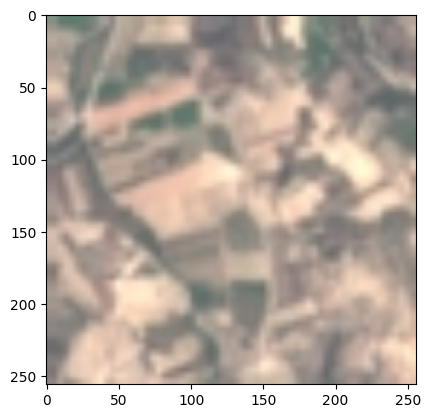

In [4]:
# Example data point visualization
random_image = train_dataset[13421][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image label:", train_dataset[13421][1])
plt.imshow(random_image)
plt.show()

In [5]:
# Define the path where the entire model will be saved
model_path = './outputs/MobileViT2_1st.pth'

# Load the model for inference
model_name = "apple/mobilevitv2-1.0-imagenet1k-256"
feature_extractor = AutoImageProcessor.from_pretrained(model_name)
loaded_model = MobileViTV2ForImageClassification.from_pretrained(model_name)

# Modify the classifier to match the number of classes
loaded_model.classifier = nn.Linear(loaded_model.classifier.in_features, len(class_names))

# Load the state dictionary
loaded_model.load_state_dict(torch.load(model_path))

if USE_CUDA:
    loaded_model = loaded_model.cuda()

print('Model loaded and ready for inference')

Model loaded and ready for inference



Loaded model test results: Loss=0.034443413202527556 | Accuracy=99.08529048207664
Precision: 0.9908740151318551 | Recall: 0.9908529048207664
Inference Time for Loaded Model: 36.476093769073486 seconds



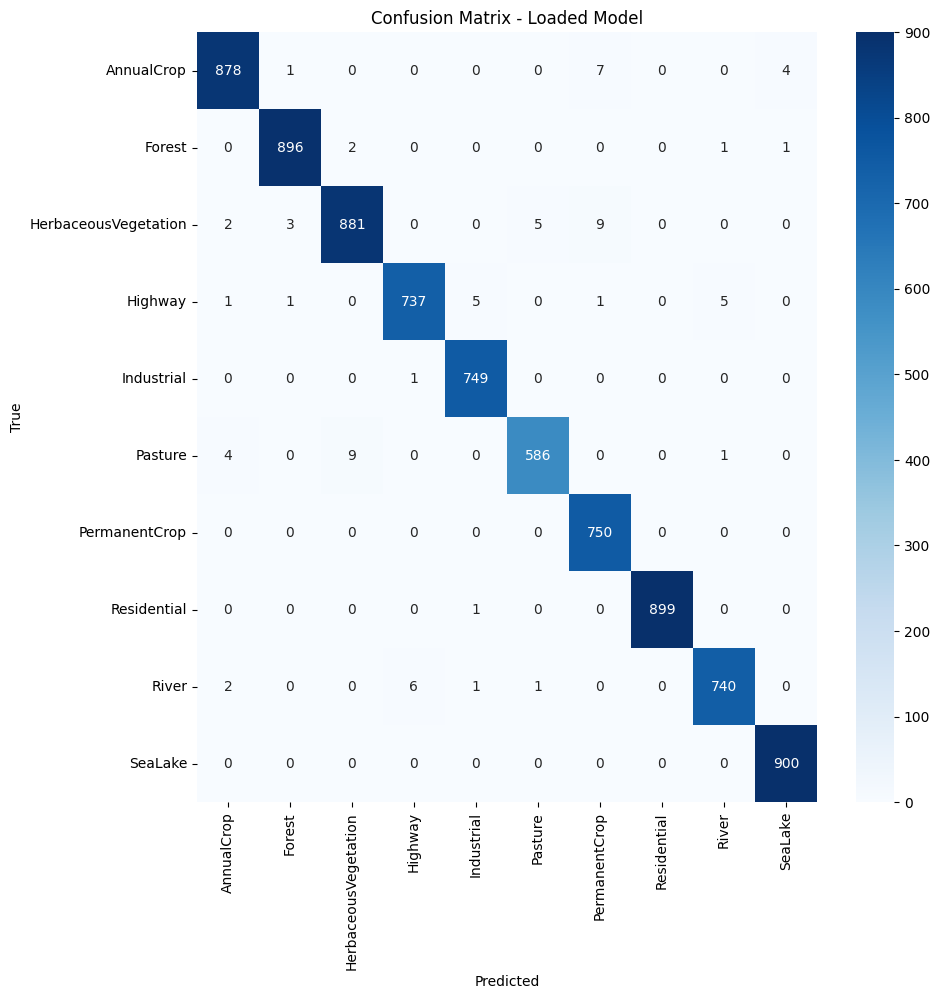

In [6]:
# Test the loaded model
loaded_model.eval()  # Put the network into evaluation mode

# Criterion for loss calculation
criterion = nn.CrossEntropyLoss()

correct = 0
iterations = 0
testing_loss = 0.0
all_preds = []
all_labels = []

# Timing for inference of the loaded model
start_time = time.time()

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = loaded_model(inputs).logits
        loss = criterion(outputs, labels)
        testing_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        iterations += 1

# End timing for inference of the loaded model
end_time = time.time()
loaded_model_inference_time = end_time - start_time

test_loss_final = testing_loss / iterations
test_accuracy_final = 100.0 * correct / len(test_dataset)
precision_final = precision_score(all_labels, all_preds, average='weighted')
recall_final = recall_score(all_labels, all_preds, average='weighted')

print(f'\nLoaded model test results: Loss={test_loss_final} | Accuracy={test_accuracy_final}')
print(f'Precision: {precision_final} | Recall: {recall_final}')
print(f'Inference Time for Loaded Model: {loaded_model_inference_time} seconds\n')

# Confusion matrix for loaded model
conf_matrix_final = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_final, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Loaded Model')
#plt.savefig('outputs/04-confusion-matrix_loaded_xLSTM.pdf')
plt.show()

In [7]:
# Calculate the clean accuracy (A_clean)
clean_accuracy = test_accuracy_final


In [8]:
# Define the severity levels and corresponding data paths
severity_levels = [1, 2, 3, 4, 5]
output_dir = './noisy_test_data/data_gaussian'

In [9]:
# Define a function to calculate the robustness score for each severity and also collect other metrics
def evaluate_and_calculate_robustness(test_loader, criterion, severity):
    loaded_model.eval()  # Put the network into evaluation mode

    correct = 0
    iterations = 0
    testing_loss = 0.0
    all_preds = []
    all_labels = []

    # Timing for inference of the loaded model
    start_time = time.time()

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            if USE_CUDA:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = loaded_model(inputs).logits
            loss = criterion(outputs, labels)
            testing_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            iterations += 1

    # End timing for inference of the loaded model
    end_time = time.time()
    inference_time = end_time - start_time

    test_loss = testing_loss / iterations
    test_accuracy = 100.0 * correct / len(test_loader.dataset)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f'\nTest results for severity {severity}: Loss={test_loss} | Accuracy={test_accuracy}')
    print(f'Precision: {precision} | Recall: {recall}')
    print(f'Inference Time: {inference_time} seconds\n')

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Severity {severity}')
    plt.show()

    # Calculate robustness score for this severity
    robustness_score = test_accuracy / clean_accuracy
    return test_loss, test_accuracy, precision, recall, inference_time, robustness_score


Test results for severity 1: Loss=0.5251323363127587 | Accuracy=87.57725587144623
Precision: 0.9249729148867153 | Recall: 0.8757725587144622
Inference Time: 35.150280237197876 seconds



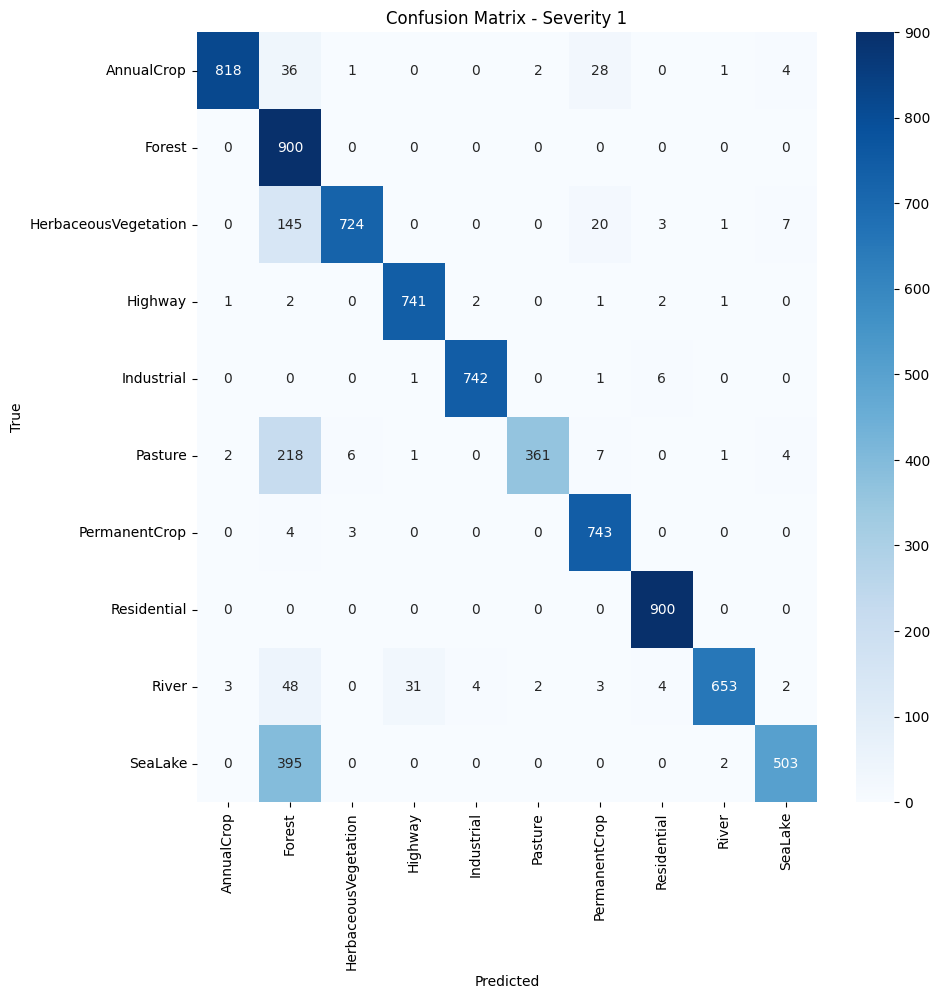

Test results for severity 1: Loss=0.5251323363127587 | Accuracy=87.57725587144623
Precision: 0.9249729148867153 | Recall: 0.8757725587144622
Inference Time: 35.150280237197876 seconds
Robustness score for severity 1: 0.8838572854291417

Test results for severity 2: Loss=1.4628393430450632 | Accuracy=68.92459826946848
Precision: 0.8312144720922049 | Recall: 0.6892459826946848
Inference Time: 34.91812491416931 seconds



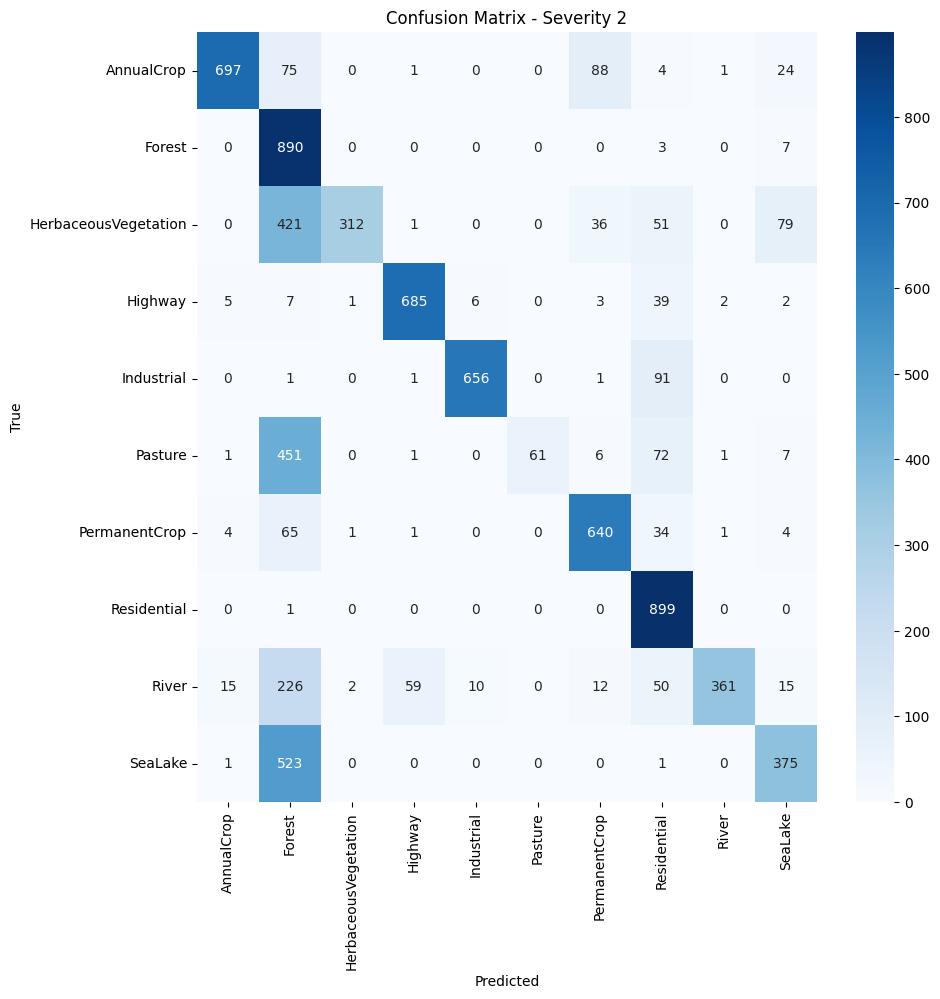

Test results for severity 2: Loss=1.4628393430450632 | Accuracy=68.92459826946848
Precision: 0.8312144720922049 | Recall: 0.6892459826946848
Inference Time: 34.91812491416931 seconds
Robustness score for severity 2: 0.6956087824351297

Test results for severity 3: Loss=2.3125853673808754 | Accuracy=58.26946847960445
Precision: 0.7061928055422185 | Recall: 0.5826946847960445
Inference Time: 35.195494174957275 seconds



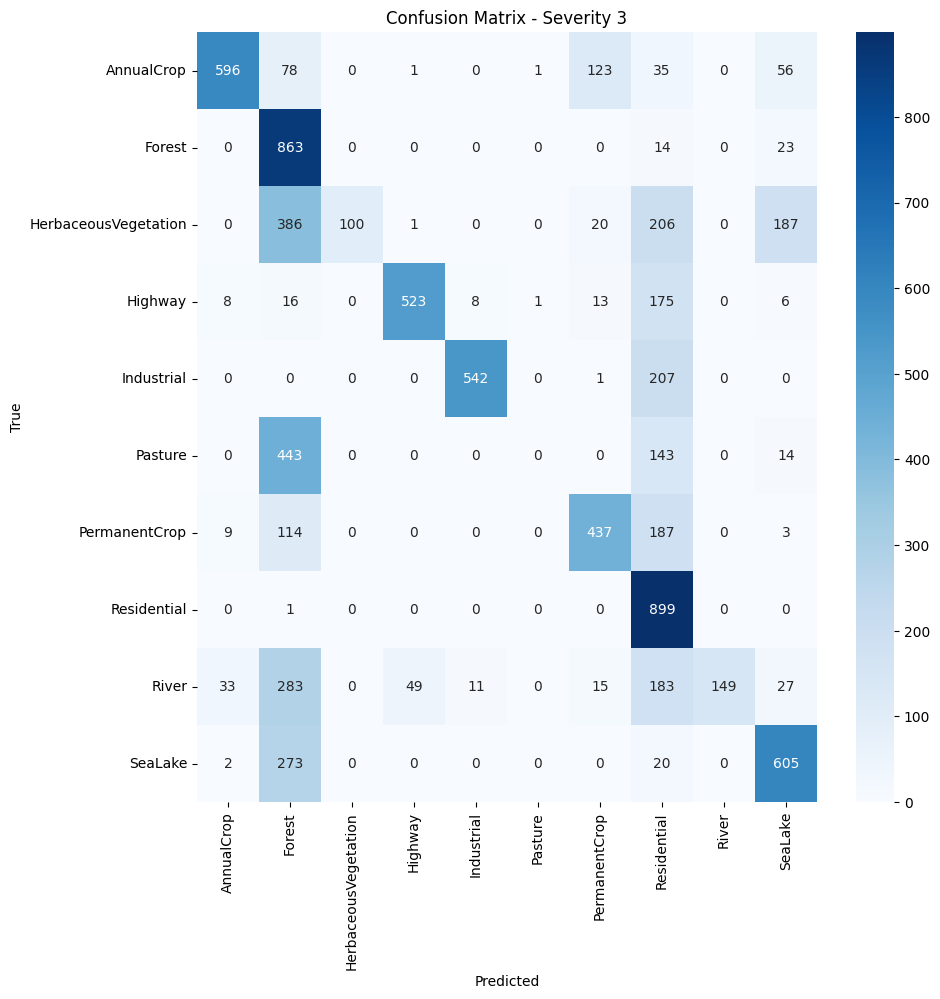

Test results for severity 3: Loss=2.3125853673808754 | Accuracy=58.26946847960445
Precision: 0.7061928055422185 | Recall: 0.5826946847960445
Inference Time: 35.195494174957275 seconds
Robustness score for severity 3: 0.5880738522954091

Test results for severity 4: Loss=3.362034314729463 | Accuracy=43.00370828182942
Precision: 0.6546527904842085 | Recall: 0.43003708281829417
Inference Time: 35.177122831344604 seconds



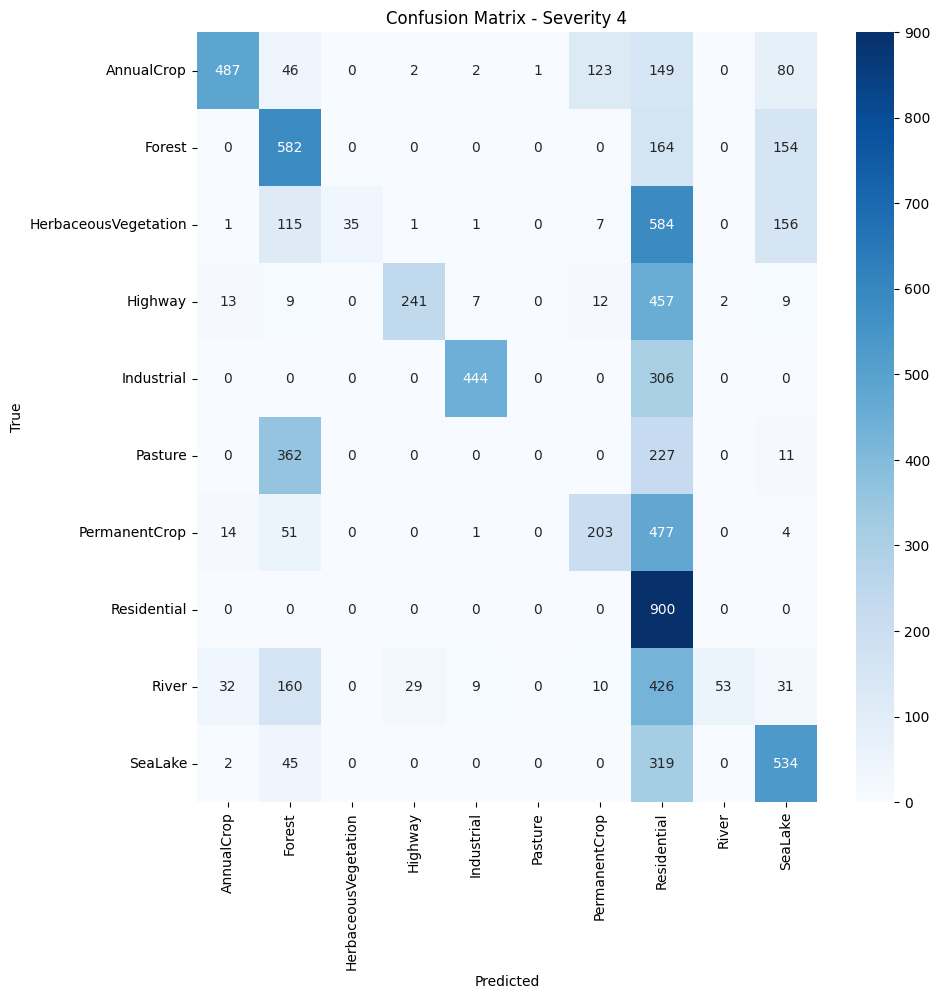

Test results for severity 4: Loss=3.362034314729463 | Accuracy=43.00370828182942
Precision: 0.6546527904842085 | Recall: 0.43003708281829417
Inference Time: 35.177122831344604 seconds
Robustness score for severity 4: 0.4340069860279441


c:\Users\thanh-dung.le\.conda\envs\torch-gpu\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test results for severity 5: Loss=4.628955159637909 | Accuracy=26.131025957972806
Precision: 0.622591938366569 | Recall: 0.26131025957972803
Inference Time: 35.19728207588196 seconds



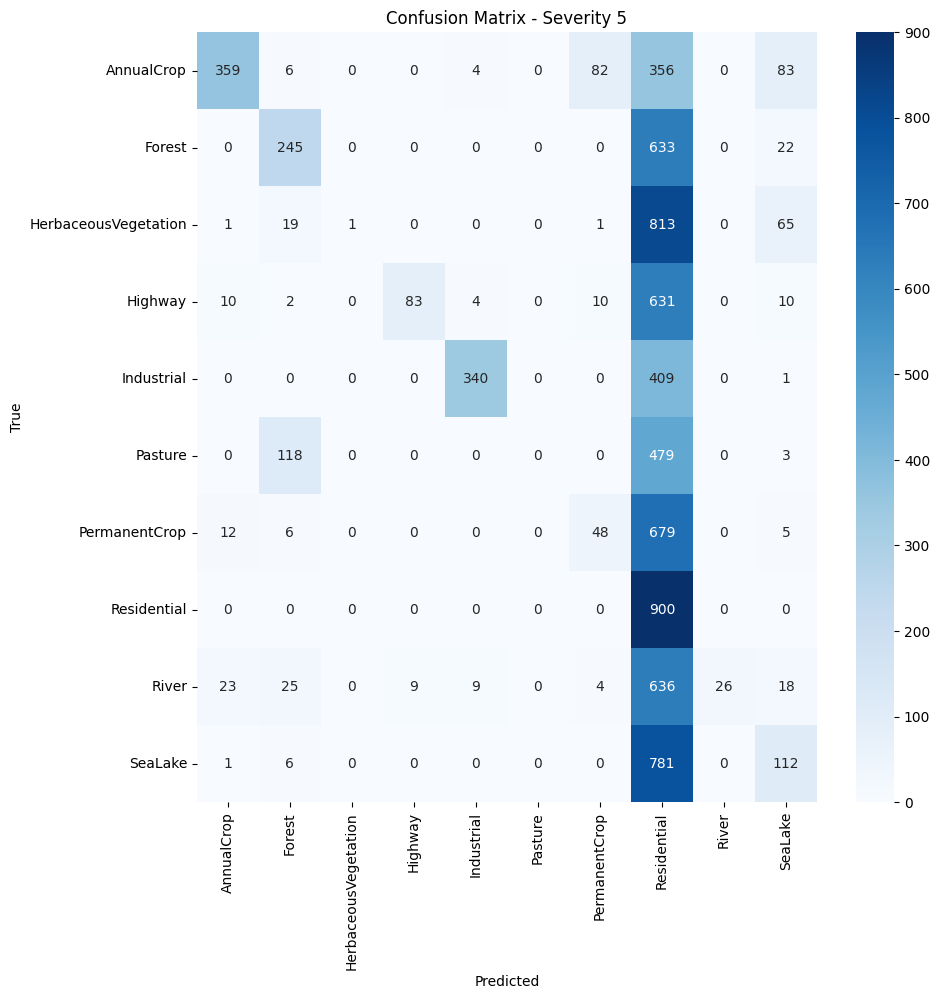

Test results for severity 5: Loss=4.628955159637909 | Accuracy=26.131025957972806
Precision: 0.622591938366569 | Recall: 0.26131025957972803
Inference Time: 35.19728207588196 seconds
Robustness score for severity 5: 0.26372255489021956
Overall Robustness Score: 0.5730538922155688


In [10]:
# Calculate robustness scores for each severity level
severity_levels = [1, 2, 3, 4, 5]
robustness_scores = []

for severity in severity_levels:
    # Define the data transformation
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load the noisy test dataset
    noisy_test_path = os.path.join(output_dir, f'severity_{severity}')
    noisy_test_dataset = datasets.ImageFolder(noisy_test_path, data_transforms)
    noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Evaluate the model on the noisy test dataset and calculate robustness score
    test_loss, test_accuracy, precision, recall, inference_time, robustness_score = evaluate_and_calculate_robustness(noisy_test_loader, criterion, severity)
    robustness_scores.append(robustness_score)

    # Print the results
    print(f'Test results for severity {severity}: Loss={test_loss} | Accuracy={test_accuracy}')
    print(f'Precision: {precision} | Recall: {recall}')
    print(f'Inference Time: {inference_time} seconds')
    print(f'Robustness score for severity {severity}: {robustness_score}')

# Calculate the overall robustness score
overall_robustness_score = np.mean(robustness_scores)
print(f'Overall Robustness Score: {overall_robustness_score}')